In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
columns = ['id','Entity','Label','Message']
df = pd.read_csv('./datasets/twitter_training.csv', names=columns)
df.sample(5)

id                  Entity       Label  \
73001   8904                  Nvidia    Negative   
19967  12617            WorldOfCraft     Neutral   
34002   6640                Fortnite  Irrelevant   
28829    559             ApexLegends     Neutral   
52251  10576  RedDeadRedemption(RDR)    Negative   

                                                 Message  
73001  from nvidia.com/en-us/geforce/... Shop<unk> on...  
19967  World of Warcraft on Steam celebrates Nightfal...  
34002  My advice when you suck like me .  .  .  . vm....  
28829  @PlayApex<unk>? this website has get really sc...  
52251                                               DAMN

In [3]:
df.shape

(74682, 4)

In [4]:
df.dtypes

id          int64
Entity     object
Label      object
Message    object
dtype: object

In [5]:
df.isna().sum()

id           0
Entity       0
Label        0
Message    686
dtype: int64

In [6]:
df = df.dropna(subset=['Message'])

In [7]:
df.duplicated().sum()

2340

In [8]:
df.drop_duplicates(inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71656 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       71656 non-null  int64 
 1   Entity   71656 non-null  object
 2   Label    71656 non-null  object
 3   Message  71656 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


# EDA

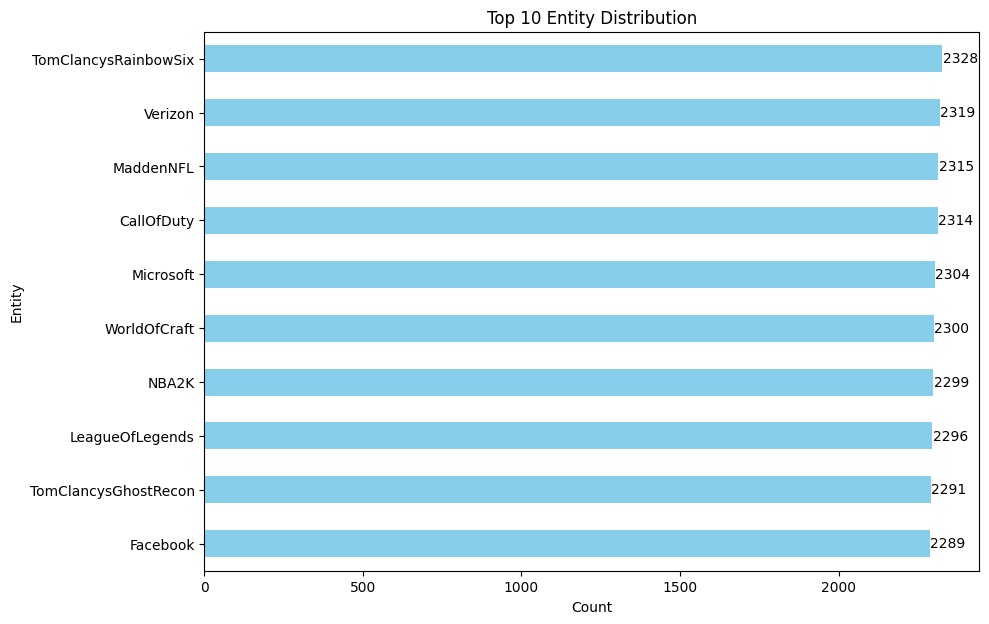

In [10]:
value_counts = df['Entity'].value_counts().head(10).sort_values(ascending=True)
value_counts.plot(kind='barh', color='skyblue', figsize=(10,7))

for i, v in enumerate(value_counts):
    plt.text(v + 0.8, i, str(v), ha='left', va='center')

# Add title and labels
plt.title('Top 10 Entity Distribution')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.show()

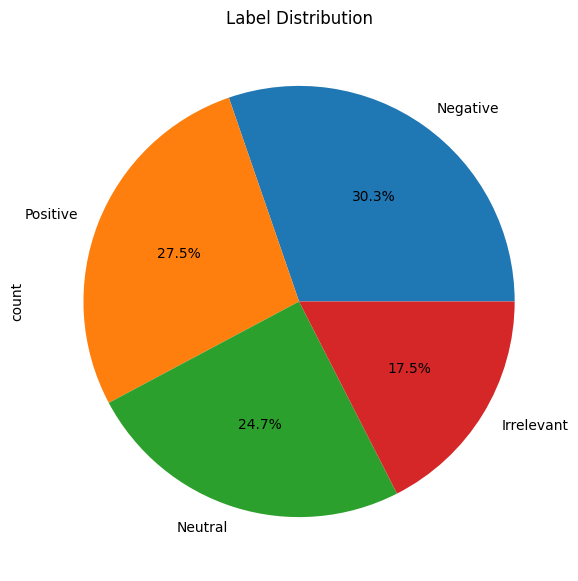

In [11]:
value_counts = df['Label'].value_counts()
value_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 7))
plt.title('Label Distribution')
plt.show()

<Axes: xlabel='Label', ylabel='count'>

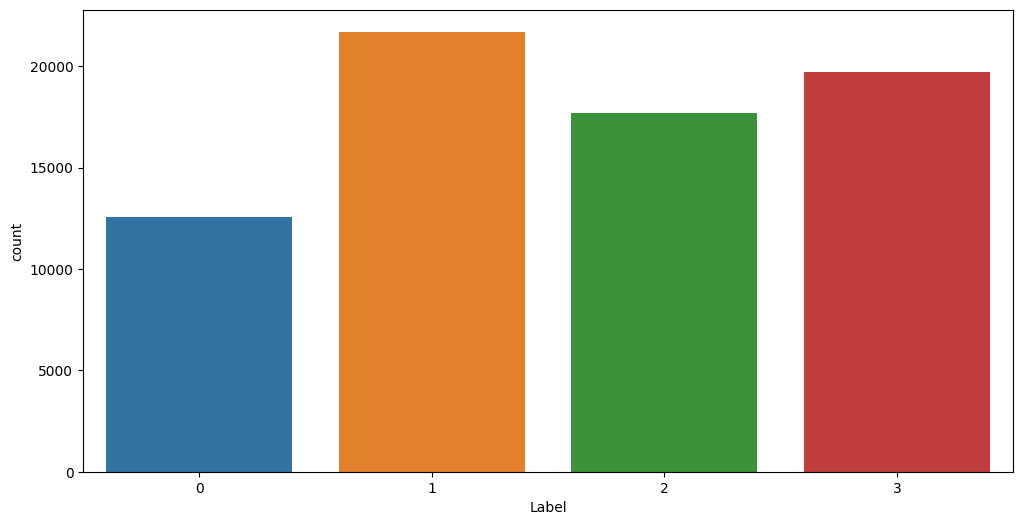

In [41]:
plt.figure(figsize=(12,6))
sns.countplot(x='Label',data=df)

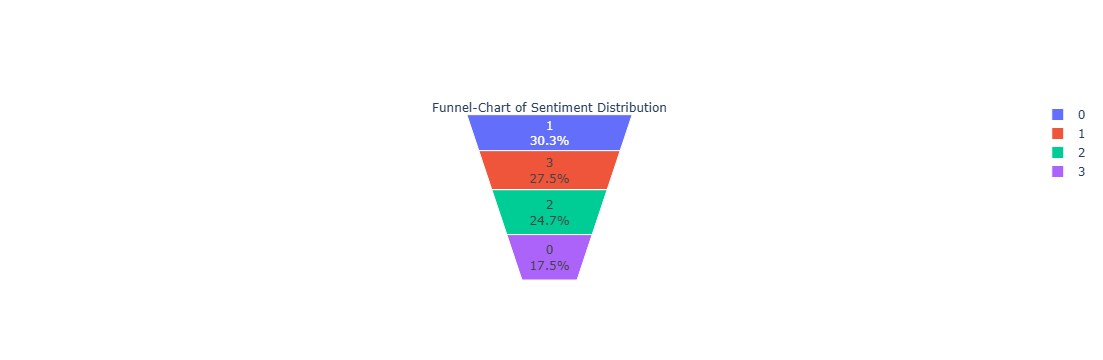

In [47]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

temp = df['Label'].value_counts()

fig = go.Figure(go.Funnelarea(
    text =temp.index,
    values = temp.values,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

# Feature Engineering

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [35]:
import spacy
import re
# !python -m spacy download en_core_web_sm

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

In [55]:
print(nlp.Defaults.stop_words)

{'now', 'third', 'has', 'perhaps', 'at', 'me', 'else', 'we', 'used', 'to', 'here', 'fifteen', 'any', 'anyway', 'ours', 'under', 'just', 'themselves', 'must', 'see', 'where', 'out', 'whenever', 'go', 'throughout', 'alone', 'everyone', 're', 'thereafter', 'side', "n't", 'that', 'amount', 'whereafter', 'n’t', '’s', 'another', 'beyond', 'below', 'eleven', 'moreover', 'rather', 'namely', 'twenty', 'using', 'almost', 'afterwards', 'yours', '‘ve', "'re", 'yet', 'whither', 'these', 'himself', 'have', 'might', 'towards', 'mostly', 'several', "'d", 'others', 'keep', 'behind', "'ve", 'nevertheless', 'a', 'together', 'on', 'if', 'until', 'you', 'someone', 'for', 'had', 'least', 'and', 'became', 'wherever', 'indeed', 'eight', 'within', 'latterly', 'get', 'doing', 'whom', 'nowhere', '’ll', 'across', 'about', 'very', 'therein', 'it', 'why', 'seemed', 'herein', 'wherein', 'thru', '’re', 'whereas', 'back', 'how', 'upon', "'m", 'always', 'next', '‘re', 'since', 'anywhere', 'be', 'done', 'should', 'also'

In [68]:
def preprocess(text):
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)  # remove links
    text = re.sub(r"[^a-zA-Z\s]", "", text) # remove numbers and sympols
    text = re.sub(r'\s+', ' ', text) # remove extra spaces
    doc = nlp(text, disable=["ner", "parser", "senter"])  # tokenize text / Disable unnecessary components (NER, parser))

    # remove stop words and punctuation and lemmatize the text
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    return " ".join(filtered_tokens) 

In [67]:
print(preprocess("I want to die !!!! Why is my life so hard... Fuck this shit."))

want die life hard Fuck shit


In [69]:
df['Preprocessed_Message'] = df['Message'].apply(preprocess) 

In [27]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [70]:
df[df['Label']==2].sample(15)

id                     Entity  Label  \
31325   7379            LeagueOfLegends      2   
72753   8863                     Nvidia      2   
73277   8952                     Nvidia      2   
15409   3037                      Dota2      2   
54868   2222                 CallOfDuty      2   
3136    1745  CallOfDutyBlackopsColdWar      2   
59650   3424                   Facebook      2   
46162  11922                    Verizon      2   
74507   9171                     Nvidia      2   
60364   3543                   Facebook      2   
37651   5256                Hearthstone      2   
67386   7140            johnson&johnson      2   
69489   3904              Cyberpunk2077      2   
39617   5599                Hearthstone      2   
1030    2582                Borderlands      2   

                                                 Message  \
31325  I actually make them play Pokemon league of le...   
72753  Great article on @hboelman on "Running Azure G...   
73277  Starting their AI journey with its unique part...   
15409              Dice with honor stfu and press ur bkb   
54868  For Thank it you for gently listening @Infinit...   
3136   Yes, it ’ s pretty violent. But holy dammit, w...   
59650  Agent Coworker : They got a vaccine and have c...   
46162  ² The ninth best song Verizon Wireless plans i...   
74507                                                You   
60364  And i like when my parents about ’ friends rep...   
37651  Tired of wasting dust on expensive decks that ...   
67386  20 Volunteers Suffer Serious Reactions to John...   
69489  Wake the fuck up guy, we have a city to burn. ...   
39617  cats eat giant spiders of their sleep each yea...   
1030   Keep your chin held up, or SO GO I CAN SMASH I...   

                                    Preprocessed_Message  
31325  actually play Pokemon league legend badly holy...  
72753  great article hboelman run Azure GPU Ready Azu...  
73277  start AI journey unique partnership HPE Apollo...  
15409                       dice honor stfu press ur bkb  
54868  thank gently listen InfinityWard finally wear ...  
3136   yes s pretty violent holy dammit love franchis...  
59650  Agent Coworker get vaccine cure pretty like ma...  
46162    ninth good song Verizon Wireless plan April ...  
74507                                                     
60364  like parent friend reply political facebook ra...  
37651  tired waste dust expensive deck suck try buy s...  
67386    volunteer suffer Reactions Johnson Johnsons ...  
69489  wake fuck guy city burn RhandlerR pictwitterco...  
39617  cat eat giant spider sleep year centaur rib ca...  
1030   chin hold smash HAMMER Chaotic Digital review ...

In [74]:
df.isnull().sum()

id                      0
Entity                  0
Label                   0
Message                 0
Preprocessed_Message    0
dtype: int64

In [ ]:
df = df.dropna()

C:\Users\joena\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



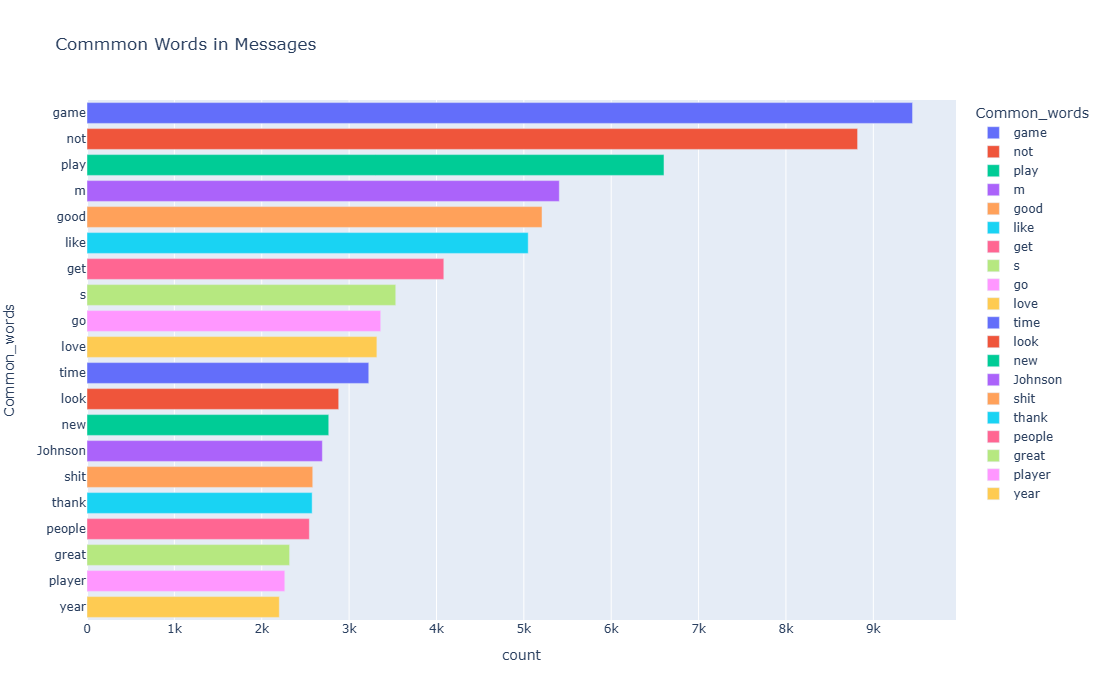

In [75]:
from collections import Counter

x = df['Preprocessed_Message'].apply(lambda x: str(x).split())
top = Counter([item for sublist in x for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Messages', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

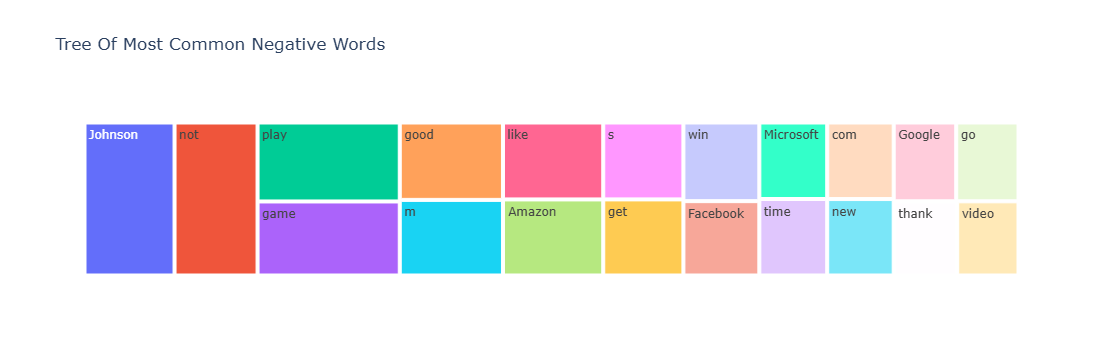

In [76]:
x = df[df['Label']==2]['Preprocessed_Message'].apply(lambda x: str(x).split())
top = Counter([item for sublist in x for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

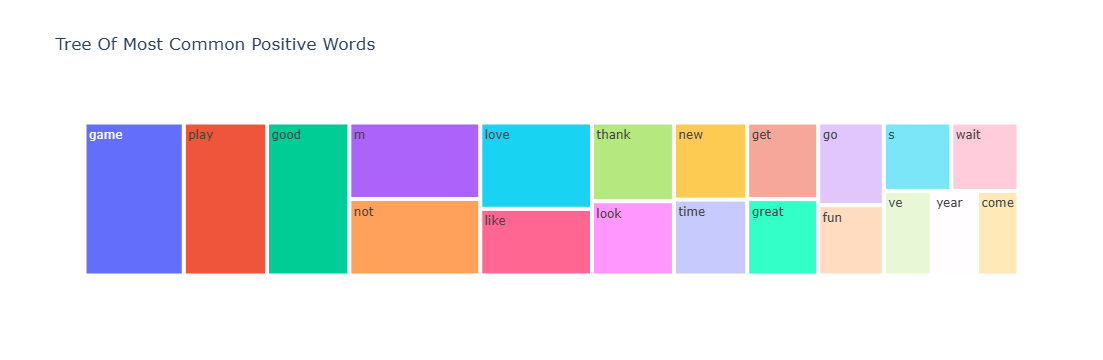

In [77]:
x = df[df['Label']==3]['Preprocessed_Message'].apply(lambda x: str(x).split())
top = Counter([item for sublist in x for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree Of Most Common Positive Words')
fig.show()

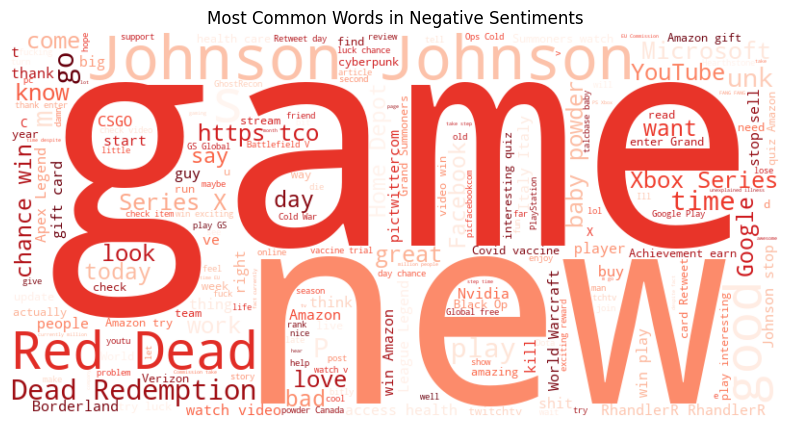

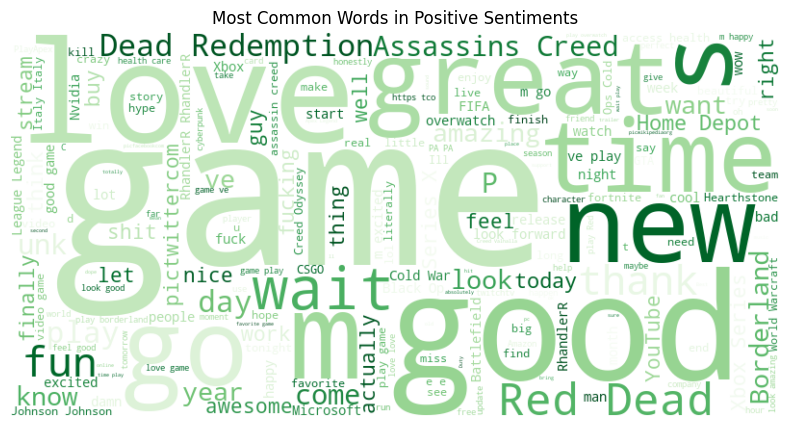

In [78]:
from wordcloud import WordCloud

# negative words
negative_text = " ".join(df[df['Label'] == 2]['Preprocessed_Message'])

negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Negative Sentiments')
plt.show()

# positive words
positive_text = " ".join(df[df['Label'] == 3]['Preprocessed_Message'])

positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Positive Sentiments')
plt.show()

# Training Model

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['Preprocessed_Message'],
                                                    df['Label'], 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Label'])


In [31]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (57324,)
Shape of X_test:  (14332,)


In [32]:
## Naive Bayes Model
clf = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer(ngram_range=(3, 3))),
    ('naive_bayes', (MultinomialNB()))         
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score:  0.8343566843427296
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.85      2507
           1       0.66      0.99      0.79      4340
           2       0.98      0.83      0.90      3542
           3       0.97      0.73      0.83      3943

    accuracy                           0.83     14332
   macro avg       0.90      0.82      0.84     14332
weighted avg       0.88      0.83      0.84     14332



In [33]:
# Random Forest Classifier
clf = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer(ngram_range=(3, 3))),
    ('random_forest', (RandomForestClassifier()))         
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score:  0.7869801842031817
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80      2507
           1       0.96      0.74      0.84      4340
           2       0.95      0.72      0.82      3542
           3       0.58      0.97      0.73      3943

    accuracy                           0.79     14332
   macro avg       0.87      0.78      0.80     14332
weighted avg       0.86      0.79      0.80     14332

